# Lab 02: Softmax Regression Project

## Mục tiêu
1. Cài đặt thuật toán Softmax Regression từ đầu (NumPy).
2. Thiết kế và so sánh 3 loại đặc trưng:
   - Pixel Intensity (Flatten)
   - Edge Detection (Canny)
   - Block Averaging
3. Đánh giá hiệu năng và phân tích kết quả.

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import time
import os

# Import module tự viết
from model import SoftmaxRegression
from features import FeatureExtractor

# Cấu hình hiển thị ảnh rõ nét hơn trên màn hình Retina
%config InlineBackend.figure_format = 'retina'

# Cấu hình Hyperparameters
CONFIG = {
    'lr': 0.1,
    'reg': 1e-4,
    'epochs': 20,
    'batch_size': 128,
    'n_classes': 10,
    'val_split': 0.1
}

print("Đã import thư viện và cấu hình thành công!")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Đã import thư viện và cấu hình thành công!


In [3]:
def load_mnist_data():
    try:
        from tensorflow.keras.datasets import mnist
        (X_train_raw, y_train), (X_test_raw, y_test) = mnist.load_data()
        print(f"Train shape: {X_train_raw.shape}, Label shape: {y_train.shape}")
        print(f"Test shape: {X_test_raw.shape}, Label shape: {y_test.shape}")
        return X_train_raw, y_train, X_test_raw, y_test
    except ImportError:
        print("Lỗi: Cần cài đặt tensorflow để tải data mẫu.")
        return None, None, None, None

X_train_raw, y_train, X_test_raw, y_test = load_mnist_data()

/Users/todanh/Downloads/ML/ML_Lab2_SoftmaxRegression/pyenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Train shape: (60000, 28, 28), Label shape: (60000,)
Test shape: (10000, 28, 28), Label shape: (10000,)


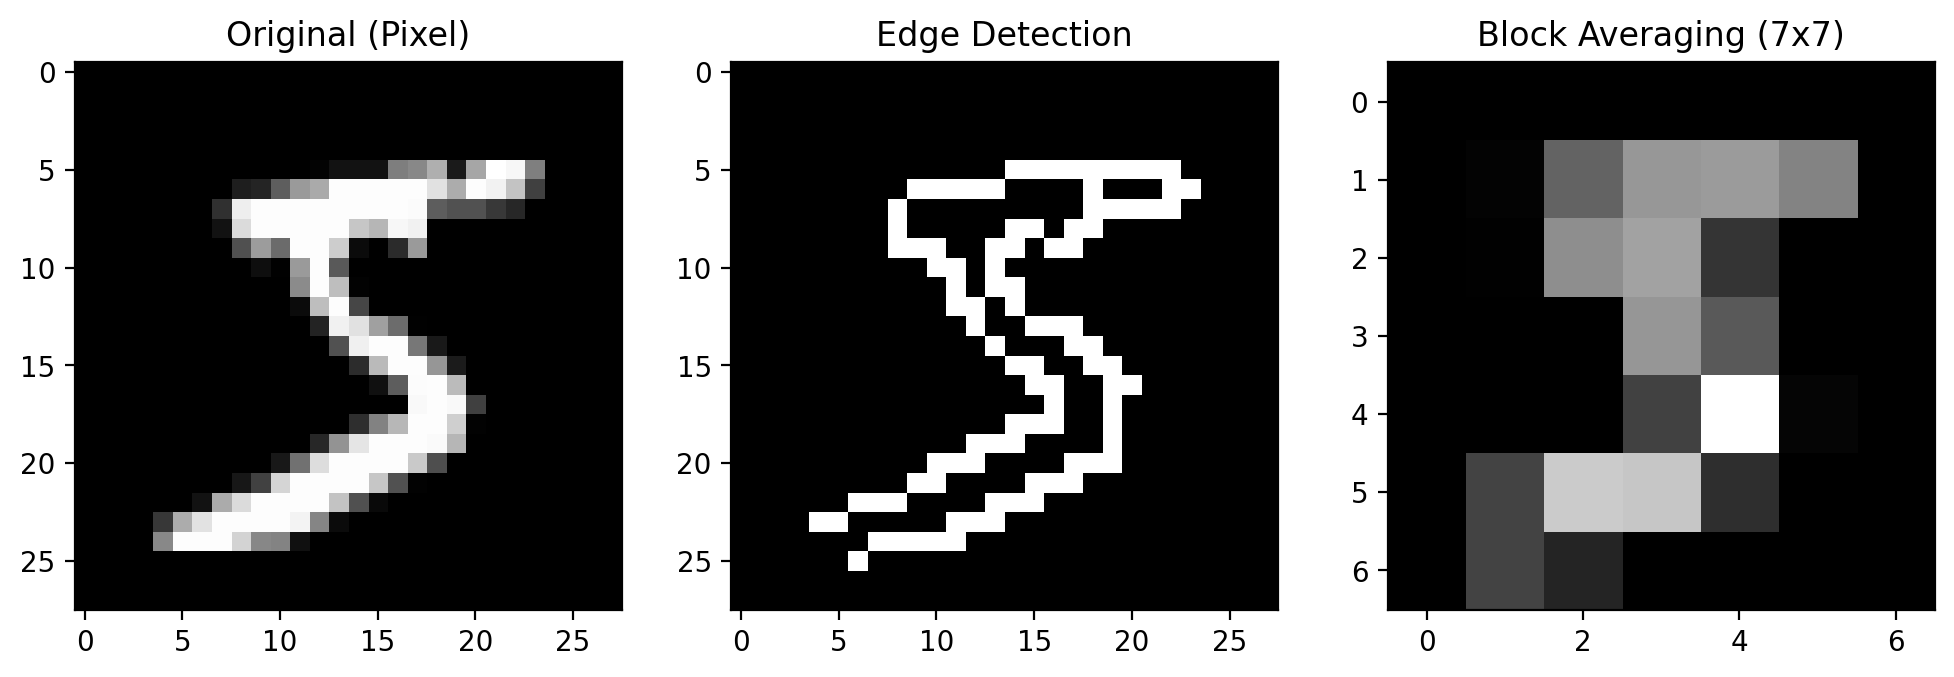

In [4]:
def visualize_features(image):
    """Hàm vẽ minh họa 3 loại đặc trưng trên cùng 1 ảnh"""
    # 1. Pixel (Original)
    original = image
    
    # 2. Edge (Canny) - Cần ép kiểu về uint8
    edge = FeatureExtractor.get_edge_features(image[np.newaxis, ...]).reshape(28, 28)
    
    # 3. Block Averaging (đã bị flatten nên cần reshape lại để vẽ)
    # Lưu ý: Block 4x4 trên ảnh 28x28 sẽ ra ảnh 7x7
    block = FeatureExtractor.get_block_features(image[np.newaxis, ...]).reshape(7, 7)

    # Vẽ biểu đồ
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title("Original (Pixel)")
    
    axes[1].imshow(edge, cmap='gray')
    axes[1].set_title("Edge Detection")
    
    axes[2].imshow(block, cmap='gray')
    axes[2].set_title("Block Averaging (7x7)")
    
    plt.show()

# Lấy thử ảnh đầu tiên trong tập train để vẽ
sample_img = X_train_raw[0]
visualize_features(sample_img)

In [10]:
def train_and_evaluate_notebook(feature_name, extract_func, X_raw, y, X_test_raw, y_test):
    print(f"\n{'='*10} ĐANG XỬ LÝ: {feature_name} {'='*10}")
    
    # 1. Trích xuất đặc trưng
    print(f"[*] Đang trích xuất đặc trưng...")
    start_time = time.time()
    X_feat = extract_func(X_raw)
    X_test_feat = extract_func(X_test_raw)
    print(f"    - Thời gian: {time.time() - start_time:.2f}s")
    print(f"    - Kích thước vector: {X_feat.shape[1]}")

    # 2. Split Train/Val
    num_train = int(X_feat.shape[0] * (1 - CONFIG['val_split']))
    X_train_split, y_train_split = X_feat[:num_train], y[:num_train]
    X_val_split, y_val_split = X_feat[num_train:], y[num_train:]

    # 3. Khởi tạo Model
    model = SoftmaxRegression(
        n_features=X_feat.shape[1],
        n_classes=CONFIG['n_classes'],
        lr=CONFIG['lr'],
        reg=CONFIG['reg']
    )

    # 4. Train
    print(f"[*] Bắt đầu training...")
    history = model.fit(
        X_train_split, y_train_split,
        X_val=X_val_split, y_val=y_val_split,
        epochs=CONFIG['epochs'],
        batch_size=CONFIG['batch_size'],
        verbose=False # Tắt verbose để notebook đỡ dài dòng
    )

    # 5. Evaluate
    y_pred_test = model.predict(X_test_feat)
    test_acc = np.mean(y_pred_test == y_test)
    print(f"[*] ĐỘ CHÍNH XÁC TEST: {test_acc:.4f}")

    # 6. Save
    save_path = f"model_{feature_name.lower()}.npz"
    model.save(save_path)
    
    # 7. VẼ BIỂU ĐỒ LOSS & ACCURACY (Phần thêm cho Notebook)
    plt.figure(figsize=(12, 4))
    
    # Subplot 1: Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.title(f'{feature_name} - Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Subplot 2: Validation Accuracy
    if history['val_acc']:
        plt.subplot(1, 2, 2)
        plt.plot(history['val_acc'], label='Val Acc', color='orange')
        plt.title(f'{feature_name} - Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
    plt.show()

    return test_acc, history['train_loss'][-1]


========== ĐANG XỬ LÝ: PIXEL ==========
[*] Đang trích xuất đặc trưng...
    - Thời gian: 0.12s
    - Kích thước vector: 784
[*] Bắt đầu training...
[*] ĐỘ CHÍNH XÁC TEST: 0.9224


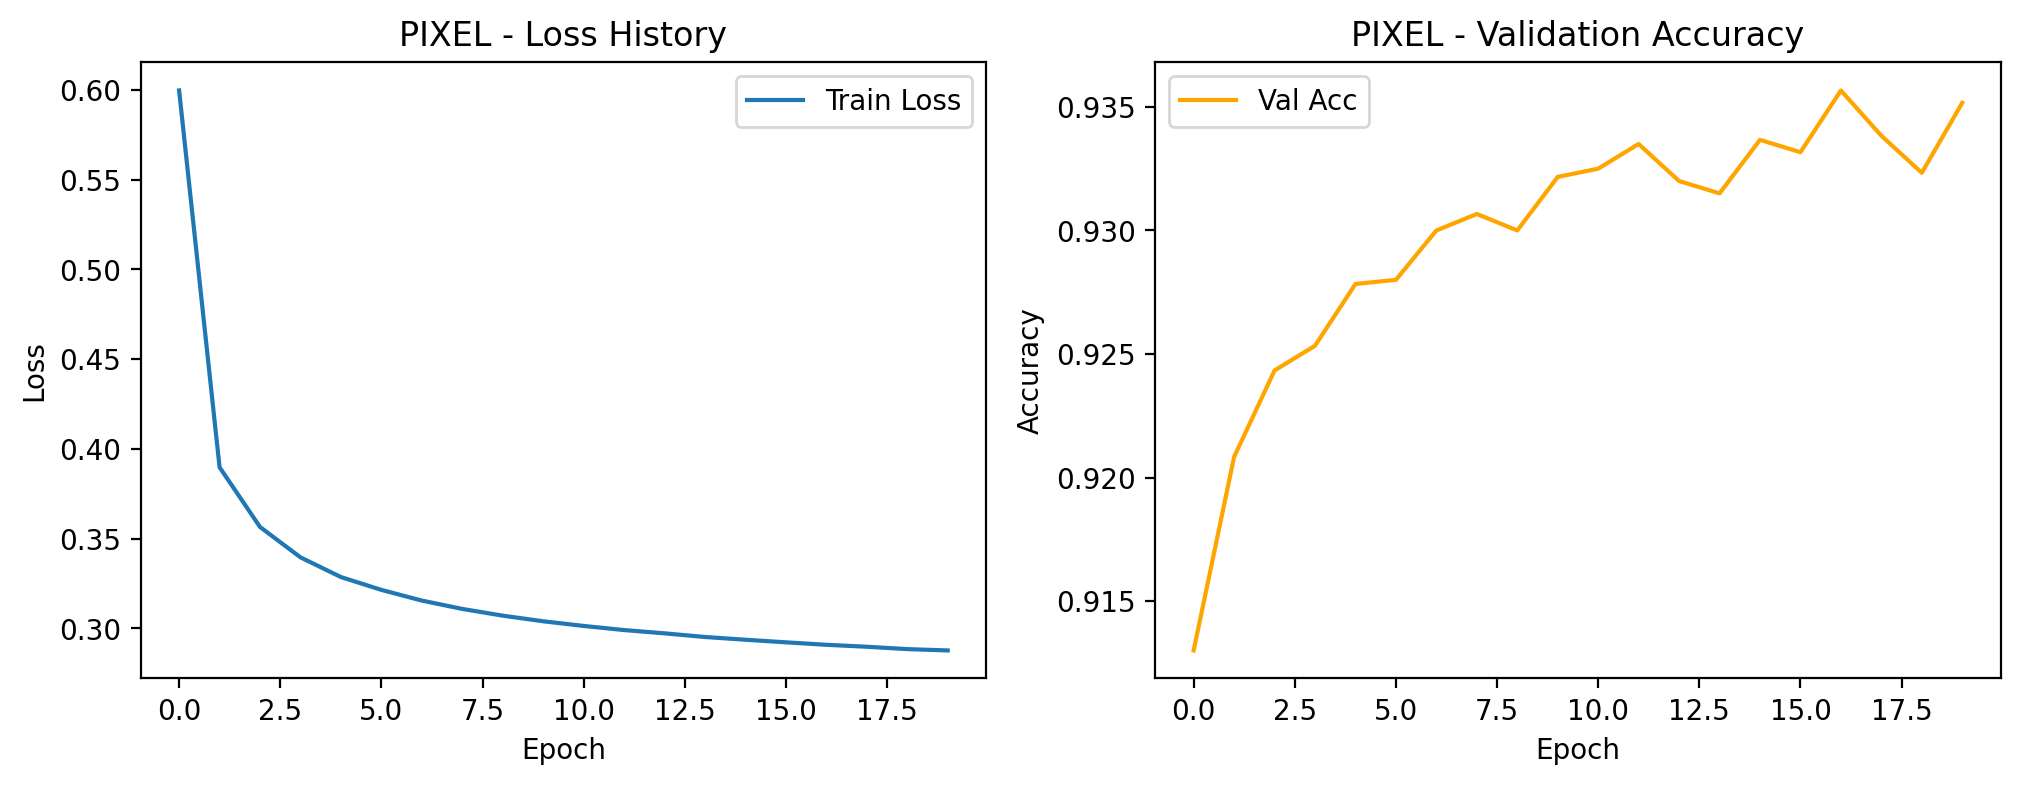


========== ĐANG XỬ LÝ: BLOCK_AVG ==========
[*] Đang trích xuất đặc trưng...
    - Thời gian: 0.21s
    - Kích thước vector: 49
[*] Bắt đầu training...
[*] ĐỘ CHÍNH XÁC TEST: 0.8692


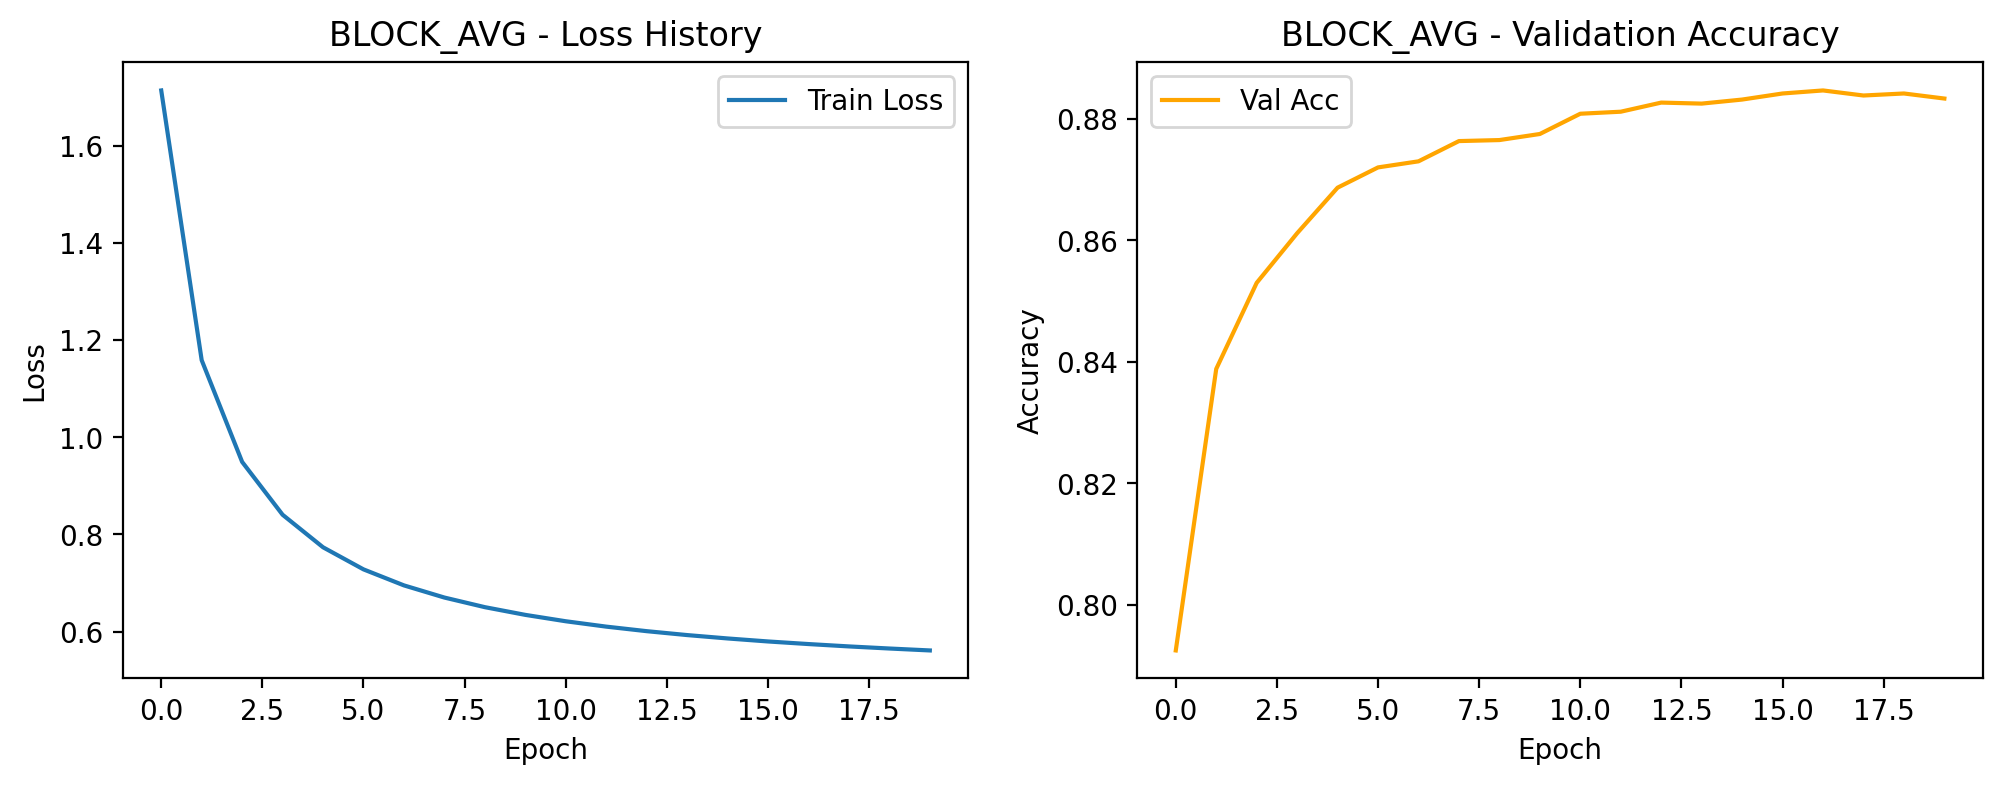


========== ĐANG XỬ LÝ: EDGE ==========
[*] Đang trích xuất đặc trưng...
    - Thời gian: 3.19s
    - Kích thước vector: 784
[*] Bắt đầu training...
[*] ĐỘ CHÍNH XÁC TEST: 0.8818


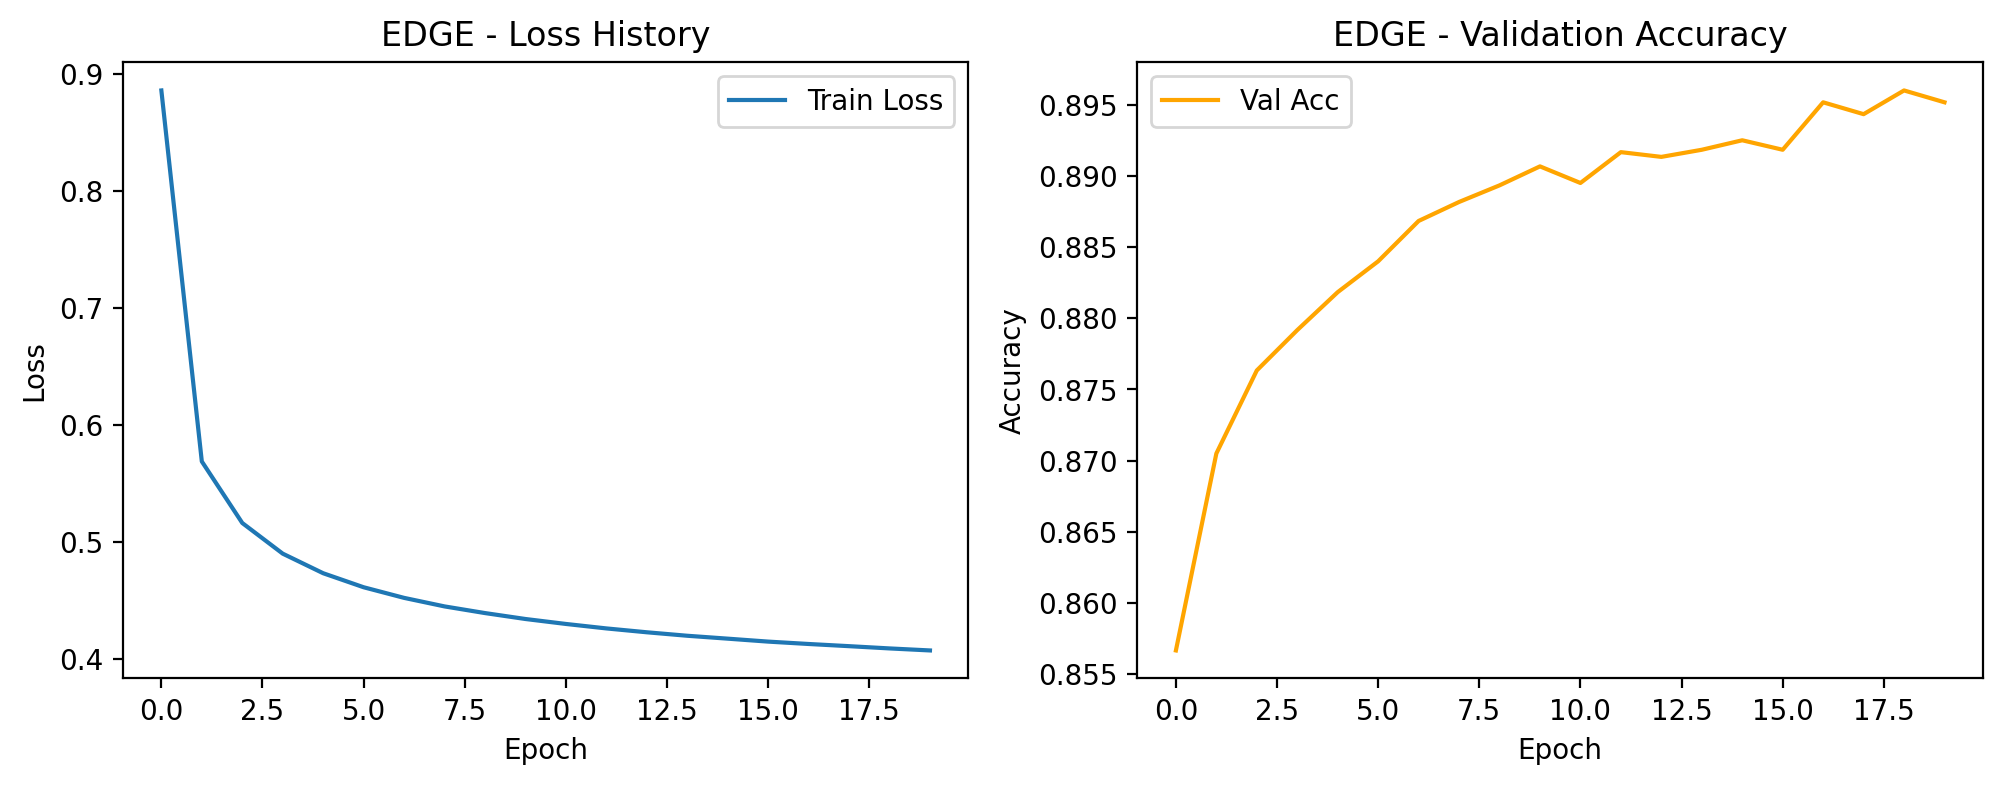

In [11]:
# Danh sách thí nghiệm
experiments = {
    "PIXEL": FeatureExtractor.get_pixel_features,
    "BLOCK_AVG": FeatureExtractor.get_block_features,
    "EDGE": FeatureExtractor.get_edge_features 
}

results = {}

# Chạy lần lượt
for name, func in experiments.items():
    # Lưu ý: EDGE chạy sẽ hơi lâu (1-3 phút)
    acc, loss = train_and_evaluate_notebook(name, func, X_train_raw, y_train, X_test_raw, y_test)
    results[name] = {'Accuracy': acc, 'Final Loss': loss}


TỔNG KẾT KẾT QUẢ SO SÁNH
Feature Type    | Test Accuracy   | Final Loss     
--------------------------------------------------
PIXEL           | 0.9224          | 0.2878
BLOCK_AVG       | 0.8692          | 0.5613
EDGE            | 0.8818          | 0.4074


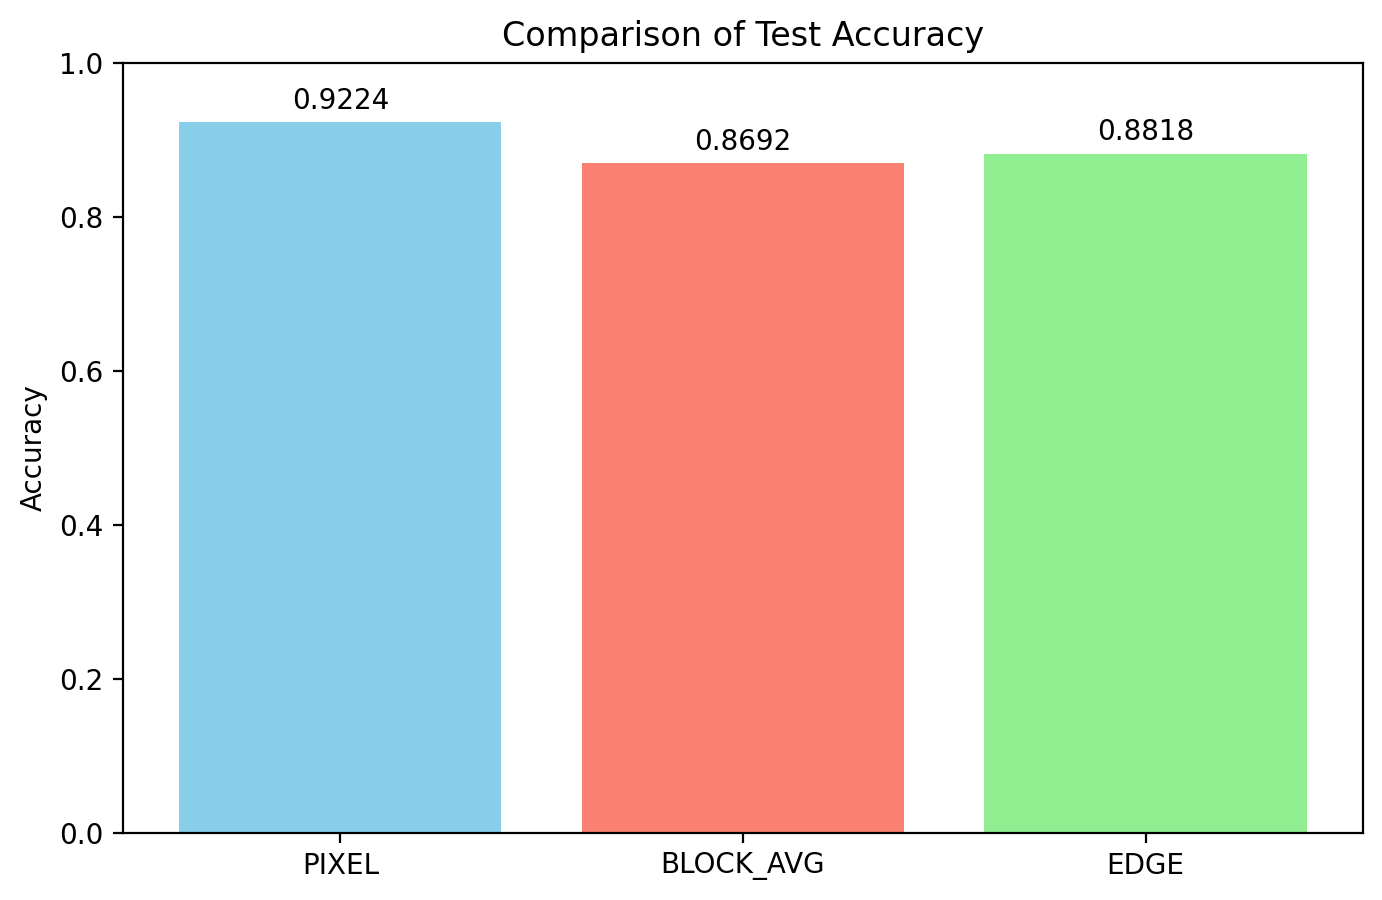

In [12]:
print(f"\n{'='*45}")
print("TỔNG KẾT KẾT QUẢ SO SÁNH")
print(f"{'='*45}")
print(f"{'Feature Type':<15} | {'Test Accuracy':<15} | {'Final Loss':<15}")
print("-" * 50)

# Vẽ biểu đồ so sánh cột (Bar Chart)
names = []
accs = []

for name, metrics in results.items():
    print(f"{name:<15} | {metrics['Accuracy']:.4f}          | {metrics['Final Loss']:.4f}")
    names.append(name)
    accs.append(metrics['Accuracy'])

print(f"{'='*45}")

# Vẽ biểu đồ so sánh Accuracy
plt.figure(figsize=(8, 5))
bars = plt.bar(names, accs, color=['skyblue', 'salmon', 'lightgreen'])
plt.ylim(0, 1.0)
plt.title("Comparison of Test Accuracy")
plt.ylabel("Accuracy")

# Hiển thị số trên cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom')

plt.show()